In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
data_folder = "/content/drive/MyDrive/veri-madenciligi-projesi/notebooks"  # <- burayı kendi Drive klasörüne göre değiştir

# Klasördeki csv dosyalarını listele
files = [f for f in os.listdir(data_folder) if f.lower().endswith('.csv')]
print("Found CSV files:", len(files))
for f in files:
    print("-", f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found CSV files: 16
- FEDFUNDS.csv
- ECBDFR.csv
- CPI.csv
- UNRATE.csv
- IVV.csv
- GSPC.csv
- EURUSDX.csv
- DXY.csv
- PAYEMS.csv
- WALCL.csv
- ZQF.csv
- VIX.csv
- BTC-USD.csv
- STLFSI2.csv
- GCF.csv
- GDP.csv


In [4]:
import pandas as pd
import os

folder = "/content/drive/MyDrive/veri-madenciligi-projesi/notebooks"

for file in os.listdir(folder):
    if file.endswith(".csv"):
        path = os.path.join(folder, file)

        print("Temizleniyor:", file)

        # Dosyayı oku
        raw = pd.read_csv(path, header=None)

        # 1) "Date" satırını bul
        header_row = raw[raw.apply(lambda row: row.str.contains("Date", na=False)).any(axis=1)]

        if len(header_row) == 0:
            print("Başlık bulunamadı, atlandı:", file)
            continue

        header_index = header_row.index[0]

        # 2) Bu satırı header olarak ayarla
        new_header = raw.iloc[header_index]

        # 3) Header'dan sonraki gerçek verileri al
        df = raw[(header_index+1):]
        df.columns = new_header
        df.reset_index(drop=True, inplace=True)

        # 4) Gereksiz "NaN" satırları temizle
        df = df.dropna(subset=["Date"])

        # 5) Temiz dosyayı tekrar kaydet
        df.to_csv(path, index=False)

        print("Temizlendi:", file)

print("Tüm dosyalar temizlendi")


Temizleniyor: FEDFUNDS.csv
Başlık bulunamadı, atlandı: FEDFUNDS.csv
Temizleniyor: ECBDFR.csv
Temizlendi: ECBDFR.csv
Temizleniyor: CPI.csv
Temizlendi: CPI.csv
Temizleniyor: UNRATE.csv
Temizlendi: UNRATE.csv
Temizleniyor: IVV.csv
Temizlendi: IVV.csv
Temizleniyor: GSPC.csv
Temizlendi: GSPC.csv
Temizleniyor: EURUSDX.csv
Temizlendi: EURUSDX.csv
Temizleniyor: DXY.csv
Temizlendi: DXY.csv
Temizleniyor: PAYEMS.csv
Temizlendi: PAYEMS.csv
Temizleniyor: WALCL.csv
Temizlendi: WALCL.csv
Temizleniyor: ZQF.csv
Temizlendi: ZQF.csv
Temizleniyor: VIX.csv
Temizlendi: VIX.csv
Temizleniyor: BTC-USD.csv
Temizlendi: BTC-USD.csv
Temizleniyor: STLFSI2.csv
Temizlendi: STLFSI2.csv
Temizleniyor: GCF.csv
Temizlendi: GCF.csv
Temizleniyor: GDP.csv
Temizlendi: GDP.csv
Tüm dosyalar temizlendi


In [5]:
import pandas as pd
import os

folder = "/content/drive/MyDrive/veri-madenciligi-projesi/notebooks"

# Yahoo Finance dosyaları
broken_files = [
    "ZQ=F.csv", "IVV.csv", "GC=F.csv", "EURUSD=X.csv",
    "DXY.csv", "CPI.csv", "BTC-USD.csv", "^VIX.csv", "^GSPC.csv"
]

# Doğru Yahoo kolonları
correct_cols = ["Date","Close","High","Low","Open","Volume"]

for file in broken_files:
    path = os.path.join(folder, file)

    if not os.path.exists(path):
        print("Dosya yok:", file)
        continue

    print("Düzeltiliyor:", file)

    df = pd.read_csv(path, header=None)

    # Eğer Date ilk satırdaysa ve sütun adları yoksa
    if df.iloc[0].str.contains("Date", na=False).any():
        df = df[1:]  # Date satırını at
        df.columns = correct_cols[:len(df.columns)]  # mümkün olan kolonları ekle

        df.to_csv(path, index=False)
        print("Düzeltildi:", file)
    else:
        print("Zaten düzgün olabilir:", file)

print("Tüm bozuk dosyalar düzeltildi!")


Dosya yok: ZQ=F.csv
Düzeltiliyor: IVV.csv
Düzeltildi: IVV.csv
Dosya yok: GC=F.csv
Dosya yok: EURUSD=X.csv
Düzeltiliyor: DXY.csv
Düzeltildi: DXY.csv
Düzeltiliyor: CPI.csv
Düzeltildi: CPI.csv
Düzeltiliyor: BTC-USD.csv
Düzeltildi: BTC-USD.csv
Dosya yok: ^VIX.csv
Dosya yok: ^GSPC.csv
Tüm bozuk dosyalar düzeltildi!


In [6]:
#Date+Value seçen fonksiyon
import os
import pandas as pd
import numpy as np

data_folder = "/content/drive/MyDrive/veri-madenciligi-projesi/notebooks"


# listele
files = [f for f in os.listdir(data_folder) if f.lower().endswith('.csv')]
print("Found", len(files), "csv files.\n")

def load_and_select(path):
    df = pd.read_csv(path, dtype=str)

    df.columns = [c.strip() for c in df.columns]

    # Tarih sütunu bul
    date_candidates = ['Date','DATE','date','observation_date','date_time','timestamp','index']
    date_col = next((c for c in date_candidates if c in df.columns), None)

    # Eğer doğrudan yoksa header'ı farklı satırlarda arayalım (0-5 arası)
    if date_col is None:
        found = False
        for h in range(0,6):
            try:
                tmp = pd.read_csv(path, header=h, nrows=5, dtype=str)
                tmp.columns = [c.strip() for c in tmp.columns]
                if any([c for c in tmp.columns if c.lower().strip()=='date' or 'date' in c.lower()]):
                    date_col = [c for c in tmp.columns if 'date' in c.lower()][0]
                    df = pd.read_csv(path, header=h, dtype=str)
                    df.columns = [c.strip() for c in df.columns]
                    found = True
                    break
            except Exception:
                continue
        if not found and date_col is None:

            for c in df.columns[:3]:
                try:
                    pd.to_datetime(df[c].iloc[:5])
                    date_col = c
                    break
                except Exception:
                    pass

    if date_col is None:
        raise ValueError(f"No date-like column found in {os.path.basename(path)}")

    # Değer sütunu
    value_candidates = ['Adj Close','Adj_Close','AdjClose','Close','close','Value','VALUE','value']
    value_col = next((c for c in value_candidates if c in df.columns), None)

    if value_col is None:
        #sayısal tip dönüşümü
        for c in df.columns:
            try:
                _ = pd.to_numeric(df[c].dropna().iloc[:5])
                value_col = c
            except Exception:
                continue

    if value_col is None:
        raise ValueError(f"No numeric value column found in {os.path.basename(path)}")

    #  Sütün seçimi
    out = df[[date_col, value_col]].copy()
    out.columns = ['Date','Value']
    # parse date
    out['Date'] = pd.to_datetime(out['Date'], errors='coerce')
    out = out.dropna(subset=['Date'])
    # try convert Value to numeric.....
    out['Value'] = out['Value'].astype(str).str.replace(',','').str.strip()
    out['Value'] = pd.to_numeric(out['Value'], errors='coerce')
    # drop rows where Value is NaN
    out = out.dropna(subset=['Value'])
    # drop duplicates
    out = out.drop_duplicates(subset=['Date'], keep='last').sort_values('Date').reset_index(drop=True)
    return out

# quick test: load all & show heads
sample = {}
for f in files:
    p = os.path.join(data_folder, f)
    try:
        df = load_and_select(p)
        sample[f] = df.head(3)
    except Exception as e:
        sample[f] = f"ERROR: {e}"

# print results
for k,v in sample.items():
    print("==", k, "==")
    print(v)
    print()


Found 16 csv files.

== FEDFUNDS.csv ==
        Date  Value
0 2014-09-01   0.09
1 2014-10-01   0.09
2 2014-11-01   0.09

== ECBDFR.csv ==
        Date  Value
0 2014-09-17   -0.2
1 2014-09-18   -0.2
2 2014-09-19   -0.2

== CPI.csv ==
        Date      Value
0 2014-09-17  23.675552
1 2014-09-18  23.657124
2 2014-09-19  23.648230

== UNRATE.csv ==
        Date  Value
0 2014-09-01    5.9
1 2014-10-01    5.7
2 2014-11-01    5.8

== IVV.csv ==
        Date       Value
0 2014-09-17  166.160706
1 2014-09-18  167.032440
2 2014-09-19  166.835114

== GSPC.csv ==
        Date       Value
0 2014-09-17  3209420000
1 2014-09-18  3235340000
2 2014-09-19  4880220000

== EURUSDX.csv ==
        Date  Value
0 2014-09-17      0
1 2014-09-18      0
2 2014-09-19      0

== DXY.csv ==
        Date        Value
0 2014-09-17  1642.150024
1 2014-09-18  1587.500000
2 2014-09-19  1628.469971

== PAYEMS.csv ==
        Date     Value
0 2014-09-01  139563.0
1 2014-10-01  139797.0
2 2014-11-01  140090.0

== WALCL.csv 

In [7]:
# read & merge all CSVs into one DataFrame
merged = None
for f in files:
    p = os.path.join(data_folder, f)
    try:
        df = load_and_select(p)
    except Exception as e:
        print("SKIP", f, "->", e)
        continue
    colname = os.path.splitext(f)[0]  # file name without .csv
    df = df.rename(columns={'Value': colname})
    if merged is None:
        merged = df
    else:
        merged = merged.merge(df, on='Date', how='outer')

# sort and reset
merged = merged.sort_values('Date').reset_index(drop=True)
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (4068, 17)


,Date,FEDFUNDS,ECBDFR,CPI,UNRATE,IVV,GSPC,EURUSDX,DXY,PAYEMS,WALCL,ZQF,VIX,BTC-USD,STLFSI2,GCF,GDP
0,2014-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17804.228
1,2014-09-01,0.09,NaN,NaN,5.9,NaN,NaN,NaN,NaN,139563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-17,NaN,-0.2,23.675552,NaN,166.160706,3.209420e+09,0.0,1642.150024,NaN,4449588.0,1157.0,NaN,457.334015,NaN,10.0,NaN
3,2014-09-18,NaN,-0.2,23.657124,NaN,167.032440,3.235340e+09,0.0,1587.500000,NaN,NaN,1157.0,NaN,424.440002,NaN,5.0,NaN
4,2014-09-19,NaN,-0.2,23.648230,NaN,166.835114,4.880220e+09,0.0,1628.469971,NaN,NaN,1001.0,NaN,394.795990,-0.6344,4.0,NaN


In [8]:
# Temel eksik doldurma
merged_filled = merged.copy()
merged_filled = merged_filled.set_index('Date')

# forward fill then back fill
merged_filled = merged_filled.ffill().bfill()

# Eğer bazı sütunlar quarter/ monthly olduğundan çok boşsa, uyarır
na_counts = merged.isna().sum()
print("Na counts before fill:\n", na_counts[na_counts>0])

print("After fill, any Na left?", merged_filled.isna().any().any())

# reset index
merged_final = merged_filled.reset_index()

# kaydet
out_path = os.path.join(data_folder, "merged_data.csv")
merged_final.to_csv(out_path, index=False)
print("Dosya kaydedildi:", out_path)
merged_final.head()


Na counts before fill:
 FEDFUNDS    3934
ECBDFR         2
CPI         1741
UNRATE      3936
IVV         1269
GSPC        1269
EURUSDX     1171
DXY         2883
PAYEMS      3936
WALCL       3487
ZQF         1268
VIX         3281
BTC-USD        3
STLFSI2     3686
GCF         1270
GDP         4024
dtype: int64
After fill, any Na left? False
Dosya kaydedildi: /content/drive/MyDrive/veri-madenciligi-projesi/notebooks/merged_data.csv


,Date,FEDFUNDS,ECBDFR,CPI,UNRATE,IVV,GSPC,EURUSDX,DXY,PAYEMS,WALCL,ZQF,VIX,BTC-USD,STLFSI2,GCF,GDP
0,2014-07-01,0.09,-0.2,23.675552,5.9,166.160706,3.209420e+09,0.0,1642.150024,139563.0,4449588.0,1157.0,811330.0,457.334015,-0.6344,10.0,17804.228
1,2014-09-01,0.09,-0.2,23.675552,5.9,166.160706,3.209420e+09,0.0,1642.150024,139563.0,4449588.0,1157.0,811330.0,457.334015,-0.6344,10.0,17804.228
2,2014-09-17,0.09,-0.2,23.675552,5.9,166.160706,3.209420e+09,0.0,1642.150024,139563.0,4449588.0,1157.0,811330.0,457.334015,-0.6344,10.0,17804.228
3,2014-09-18,0.09,-0.2,23.657124,5.9,167.032440,3.235340e+09,0.0,1587.500000,139563.0,4449588.0,1157.0,811330.0,424.440002,-0.6344,5.0,17804.228
4,2014-09-19,0.09,-0.2,23.648230,5.9,166.835114,4.880220e+09,0.0,1628.469971,139563.0,4449588.0,1001.0,811330.0,394.795990,-0.6344,4.0,17804.228


Columns and non-null counts:
Date        4068
FEDFUNDS    4068
ECBDFR      4068
CPI         4068
UNRATE      4068
IVV         4068
GSPC        4068
EURUSDX     4068
DXY         4068
PAYEMS      4068
WALCL       4068
ZQF         4068
VIX         4068
BTC-USD     4068
STLFSI2     4068
GCF         4068
GDP         4068
dtype: int64


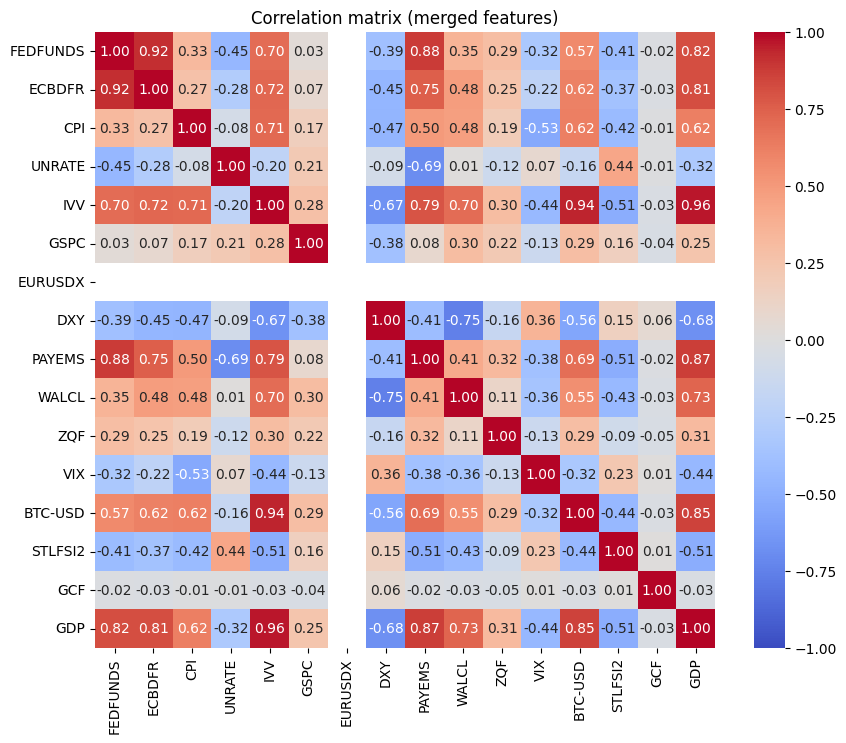

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# eksik değerlere bak
print("Columns and non-null counts:")
print(merged_final.count())

# numeric only for correlation
num = merged_final.select_dtypes(include=[np.number]).copy()
corr = num.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (merged features)")
plt.show()


In [10]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
# Merged dosyanı oku
merged_final = pd.read_csv("/content/drive/MyDrive/veri-madenciligi-projesi/notebooks/merged_data.csv")

# Tarih kolonunu düzeltme
merged_final['Date'] = pd.to_datetime(merged_final['Date'])
merged_final = merged_final.sort_values('Date')
merged_final = merged_final.set_index('Date')

# Eksik değerler
print("Eksik değerler (önce):")
print(merged_final.isnull().sum())

# Zaman serisi interpolasyonu
merged_final = merged_final.interpolate(method='linear')

# Baştaki ve sondaki boş değerler
merged_final = merged_final.ffill().bfill()

# Final kontrol
print("Eksik değerler (sonra):")
print(merged_final.isnull().sum())

# Temiz versiyon save
merged_final.to_csv("/content/drive/MyDrive/veri-madenciligi-projesi/merged_final_clean.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Eksik değerler (önce):
FEDFUNDS    0
ECBDFR      0
CPI         0
UNRATE      0
IVV         0
GSPC        0
EURUSDX     0
DXY         0
PAYEMS      0
WALCL       0
ZQF         0
VIX         0
BTC-USD     0
STLFSI2     0
GCF         0
GDP         0
dtype: int64
Eksik değerler (sonra):
FEDFUNDS    0
ECBDFR      0
CPI         0
UNRATE      0
IVV         0
GSPC        0
EURUSDX     0
DXY         0
PAYEMS      0
WALCL       0
ZQF         0
VIX         0
BTC-USD     0
STLFSI2     0
GCF         0
GDP         0
dtype: int64


In [11]:
import pandas as pd
import numpy as np

#  Dosyayı oku
path = "/content/drive/MyDrive/veri-madenciligi-projesi/merged_final_clean.csv"
df = pd.read_csv(path)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Target kolonları
df["Target_1d"] = df["BTC-USD"].shift(-1)
df["Target_7d"] = df["BTC-USD"].shift(-7)
df["Target_30d"] = df["BTC-USD"].shift(-30)
df["Target_365d"] = df["BTC-USD"].shift(-365)

#Lag'lerin sayısı
lags = [1, 3, 7, 30, 90, 365]

#Tüm kolonlara gecikme ekleme
cols = [c for c in df.columns if c not in ["Date", "Target_1d", "Target_7d", "Target_30d", "Target_365d"]]

for col in cols:
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Son satırlardaki NaN'ların temizlenmesi
df = df.dropna().reset_index(drop=True)

# Yeni dataset save
output_path = "/content/drive/MyDrive/veri-madenciligi-projesi/merged_with_lags.csv"
df.to_csv(output_path, index=False)

print("Yeni dosya kaydedildi:")
print(output_path)
print("\nÖrnek satırlar:")
print(df.head())


/tmp/ipython-input-2971186633.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
/tmp/ipython-input-2971186633.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)


Yeni dosya kaydedildi:
/content/drive/MyDrive/veri-madenciligi-projesi/merged_with_lags.csv

Örnek satırlar:
        Date  FEDFUNDS  ECBDFR        CPI  UNRATE         IVV          GSPC  \
0 2015-09-15      0.14    -0.2  23.511166     5.0  167.513916  3.239860e+09   
1 2015-09-16      0.14    -0.2  23.466616     5.0  169.016098  3.630680e+09   
2 2015-09-17      0.14    -0.2  23.573530     5.0  168.588120  4.183790e+09   
3 2015-09-18      0.14    -0.2  23.573530     5.0  165.776855  6.021240e+09   
4 2015-09-19      0.14    -0.2  23.573530     5.0  165.776855  6.021240e+09   

   EURUSDX          DXY    PAYEMS  ...  GCF_lag7  GCF_lag30  GCF_lag90  \
0      0.0   991.849976  142275.0  ...     138.0      908.0      168.0   
1      0.0   982.549988  142275.0  ...     150.0      399.0      130.0   
2      0.0   991.849976  142275.0  ...      56.0      475.0      142.0   
3      0.0  1039.979980  142275.0  ...      81.0      348.0      142.0   
4      0.0  1039.979980  142275.0  ...      81

In [15]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 13.4 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Adım 1: Veri Yükleme ve Hazırlama ---
# NOT: Bu fonksiyonu kendi veri setinizi yüklemek için düzenleyin.
# Bitcoin fiyat verileri (BTC_Close, BTC_Volume vb.) ile
# makroekonomik verileri (Faiz, Enflasyon vb.) birleştiren bir DataFrame döndürmelidir.
def load_and_prepare_data():
    """
    Örnek veri seti oluşturur ve hedef değişkenleri ekler.
    Kendi verilerinizi burada yükleyip birleştirmelisiniz.
    """
    # Örnek veri seti oluşturalım (1000 günlük veri)
    dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
    data = pd.DataFrame(index=dates)

    # Bitcoin Fiyat Verileri (Rastgele)
    data['BTC_Close'] = np.random.uniform(20000, 70000, size=1000).cumsum() + 20000
    data['BTC_Volume'] = np.random.uniform(1e9, 5e9, size=1000)

    # Makroekonomik Göstergeler (Rastgele)
    data['Faiz_Orani'] = np.random.uniform(10, 25, size=1000)
    data['Enflasyon'] = np.random.uniform(15, 60, size=1000)
    data['GSYIH_Buyume'] = np.random.uniform(-1, 5, size=1000)
    data['Issizlik_Orani'] = np.random.uniform(8, 15, size=1000)

    # Basit Teknik Göstergeler Ekleyelim
    data['SMA_50'] = data['BTC_Close'].rolling(window=50).mean()
    data['Momentum_10'] = data['BTC_Close'].diff(10)

    # Hedef Değişkenleri Oluşturma
    # Gelecekteki fiyatı bugünün satırına kaydırıyoruz
    data['Target_1d'] = data['BTC_Close'].shift(-1)
    data['Target_7d'] = data['BTC_Close'].shift(-7)
    data['Target_30d'] = data['BTC_Close'].shift(-30)
    data['Target_365d'] = data['BTC_Close'].shift(-365)

    # Hedef değişkenler oluşturulduktan sonra oluşan NaN değerleri temizle
    data.dropna(inplace=True)

    return data

# --- Adım 2: Metrik Hesaplama Fonksiyonları ---
def calculate_metrics(y_true, y_pred):
    """Verilen gerçek ve tahmin değerleri için metrikleri hesaplar."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def calculate_direction_accuracy(y_true, y_pred, X_test):
    """Fiyat değişim yönünün doğruluğunu hesaplar."""
    # Gerçek fiyatın mevcut fiyata göre yönü (1: arttı, -1: azaldı)
    true_direction = np.sign(y_true - X_test['BTC_Close'])
    # Tahmin edilen fiyatın mevcut fiyata göre yönü
    pred_direction = np.sign(y_pred - X_test['BTC_Close'])

    # Doğru tahminlerin oranını hesapla
    accuracy = np.mean(true_direction == pred_direction)
    return accuracy

# --- Adım 3: Ana İş Akışı ---

# Veriyi yükle
data = load_and_prepare_data()

# Modelleri, hedefleri ve özellik setlerini tanımla
targets = ['Target_1d', 'Target_7d', 'Target_30d', 'Target_365d']
models = {
    'Ridge': Ridge(alpha=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}
feature_sets = ['Full', 'RFE', 'PCA']
results = []

# Tüm senaryoları denemek için döngüleri başlat
print("Modeller eğitiliyor ve değerlendiriliyor...")
for target in targets:
    print(f"\n--- HEDEF: {target} ---")

    # Özellik (X) ve Hedef (y) değişkenlerini ayır
    X = data.drop(columns=targets)
    y = data[target]

    # Veriyi eğitim ve test setlerine ayır (Zaman serisi için shuffle=False önemlidir)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Veriyi ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Sütun isimlerini korumak için ölçeklenmiş veriyi DataFrame'e çevir
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    for fs_name in feature_sets:
        print(f"  Özellik Seti: {fs_name}")

        X_train_final = X_train_scaled_df
        X_test_final = X_test_scaled_df

        if fs_name == 'RFE':
            # RFE için bir tahminci (estimator) seçelim
            estimator = Ridge()
            # Özellik sayısını belirleyelim (örneğin 5)
            # Gerçek veri setinizde bu sayıyı artırabilirsiniz.
            rfe = RFE(estimator=estimator, n_features_to_select=5)
            X_train_final = rfe.fit_transform(X_train_scaled_df, y_train)
            X_test_final = rfe.transform(X_test_scaled_df)

        elif fs_name == 'PCA':
            # ÖNEMLİ: Gerçek veri setinizde çok sayıda özellik olduğunda n_components=20 kullanın.
            # Örnek verimizde az özellik olduğu için 5 olarak ayarlandı.
            n_components = min(20, X_train_final.shape[1] - 1)
            pca = PCA(n_components=n_components)
            X_train_final = pca.fit_transform(X_train_scaled_df)
            X_test_final = pca.transform(X_test_scaled_df)

        for model_name, model in models.items():
            # Modeli eğit
            model.fit(X_train_final, y_train)

            # Tahmin yap
            y_pred = model.predict(X_test_final)

            # Metrikleri hesapla
            rmse, mae, r2 = calculate_metrics(y_test, y_pred)
            dir_accuracy = calculate_direction_accuracy(y_test, y_pred, X_test)

            # Sonuçları kaydet
            result_entry = {
                'Hedef': target,
                'Model': model_name,
                'Özellik Seti': fs_name,
                'RMSE': f"{rmse:.2f}",
                'MAE': f"{mae:.2f}",
                'R2': f"{r2:.3f}",
                'Yön Doğruluğu': f"{dir_accuracy:.3f}",
                'Parametreler': model.get_params()
            }
            results.append(result_entry)
            print(f"    - Model: {model_name} | R2: {r2:.3f} | Yön Doğruluğu: {dir_accuracy:.3f}")

# --- Adım 4: Sonuçları Şık Bir Excel Dosyasına Kaydetme ve Ekranda Gösterme ---

results_df = pd.DataFrame(results)

# Sadece temel parametreleri göstermek için Parametreler sütununu sadeleştirelim
if 'KNN' in results_df['Model'].unique():
    results_df['Parametreler'] = np.where(
        results_df['Model'] == 'KNN',
        'n_neighbors=' + results_df['Parametreler'].apply(lambda p: p.get('n_neighbors', 'N/A')).astype(str),
        'alpha=' + results_df['Parametreler'].apply(lambda p: p.get('alpha', 'N/A')).astype(str)
    )

# Sütun sırasını düzenle
results_df = results_df[['Hedef', 'Model', 'Özellik Seti', 'RMSE', 'MAE', 'R2', 'Yön Doğruluğu', 'Parametreler']]


# --- YENİ EKLENEN KISIM (Excel'i Güzelleştirmek için) ---
try:
    # Excel dosyasının adını ve motorunu belirtiyoruz
    excel_dosya_adi = 'proje_sonuclari_stilli.xlsx'
    writer = pd.ExcelWriter(excel_dosya_adi, engine='xlsxwriter')

    # DataFrame'i Excel'e yazdırıyoruz
    results_df.to_excel(writer, sheet_name='Model Sonuçları', index=False)

    # Biçimlendirme için workbook ve worksheet nesnelerini alıyoruz
    workbook  = writer.book
    worksheet = writer.sheets['Model Sonuçları']

    # Başlıklar için bir format oluşturuyoruz (Kalın, Arkaplan Rengi, Kenarlık)
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'top',
        'fg_color': '#D7E4BC',  # Açık yeşil bir renk
        'border': 1
    })

    # Başlık satırına formatı uyguluyoruz
    for col_num, value in enumerate(results_df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    # Her sütunun genişliğini içeriğe göre otomatik olarak ayarlıyoruz
    # Bu, "sıkışık" görünümü engeller
    for i, col in enumerate(results_df.columns):
        # Sütundaki en uzun metnin uzunluğunu bul (başlık dahil)
        column_len = max(results_df[col].astype(str).map(len).max(), len(col))
        # Sütun genişliğini biraz pay bırakarak ayarla
        worksheet.set_column(i, i, column_len + 2)

    # Değişiklikleri kaydedip dosyayı kapatıyoruz
    writer.close()

    print(f"\nSonuçlar başarıyla '{excel_dosya_adi}' dosyasına kaydedildi.")
    print("Dosya, sütun genişlikleri ayarlanmış ve başlıkları biçimlendirilmiş olarak oluşturuldu.")

except Exception as e:
    print(f"\nExcel dosyasına kaydederken bir hata oluştu: {e}")
# -------------------------------------------------------------


# Sonuçları ekrana yazdırmaya devam et
print("\n\n" + "="*50)
print("             PROJE SONUÇ TABLOSU")
print("="*50)

# Sonuçları Markdown formatında güzel bir tablo olarak yazdır
print(results_df.to_markdown(index=False))

Modeller eğitiliyor ve değerlendiriliyor...

--- HEDEF: Target_1d ---
  Özellik Seti: Full
    - Model: Ridge | R2: 1.000 | Yön Doğruluğu: 0.975
    - Model: KNN | R2: -8.565 | Yön Doğruluğu: 0.000
  Özellik Seti: RFE
    - Model: Ridge | R2: 1.000 | Yön Doğruluğu: 0.975
    - Model: KNN | R2: -6.016 | Yön Doğruluğu: 0.000
  Özellik Seti: PCA
    - Model: Ridge | R2: 1.000 | Yön Doğruluğu: 0.975
    - Model: KNN | R2: -8.565 | Yön Doğruluğu: 0.000

--- HEDEF: Target_7d ---
  Özellik Seti: Full
    - Model: Ridge | R2: 0.999 | Yön Doğruluğu: 1.000
    - Model: KNN | R2: -8.497 | Yön Doğruluğu: 0.000
  Özellik Seti: RFE
    - Model: Ridge | R2: 0.999 | Yön Doğruluğu: 1.000
    - Model: KNN | R2: -6.000 | Yön Doğruluğu: 0.000
  Özellik Seti: PCA
    - Model: Ridge | R2: 0.999 | Yön Doğruluğu: 1.000
    - Model: KNN | R2: -8.497 | Yön Doğruluğu: 0.000

--- HEDEF: Target_30d ---
  Özellik Seti: Full
    - Model: Ridge | R2: 0.997 | Yön Doğruluğu: 1.000
    - Model: KNN | R2: -8.319 | Yön Do